# Job Analysis

1. Data Cleaning
2. EDA
3. Modeling


In [315]:
import pandas as pd
import numpy as np
import statistics
import seaborn as sns
import matplotlib.pyplot as plt

In [316]:
df = pd.read_csv('glassdoor_jobs.csv')

In [317]:
# df.head()

## Data Cleaning

#### 1) Salary Cleaning

In [318]:
df['salary'] = df['Salary Estimate'].apply(lambda x: x.split('(')[0].strip())
df['hourly'] = df['salary'].apply(lambda x: 1 if 'hour' in x.lower() else 0)
df['salary'] = df['salary'].apply(lambda x: x.replace('$',"").replace('K',"").replace('Employer Provided Salary:',"").replace("Per Hour",""))
df = df[df['salary']!= '-1']
df['min_salary'] = df['salary'].apply(lambda x: int(x.split('-')[0].strip()))
df['max_salary'] = df['salary'].apply(lambda x: int(x.split('-')[1].strip()))

df['min_salary'] = df.apply(lambda x: x.min_salary*52*40/1000 if x.hourly == 1 else x.min_salary, axis =1)
df['max_salary'] = df.apply(lambda x: x.max_salary*52*40/1000 if x.hourly == 1 else x.max_salary, axis =1)
df['avg_salary'] = (df['min_salary'] + df['max_salary'])/2


#### 2) Job Title Cleaning

In [319]:
def job_cate(x):
    x = x.lower()
    if "data scientist" in x:
        return "Data Scientist"
    elif "data engineer" in x:
        return "Data Engineer"
    elif "analyst" in x:
        return "Data Analyst"
    elif "machine learning" in x:
        return "Machine learning engineer"
    else:
        return "NA"
def seniority(x):
    x = x.lower()
    seniors = ['senior', 'sr', 'sr.']
    for senior in seniors:
        if senior in x:
            return "senior"
    return "NA"


df['Job_Category'] = df['Job Title'].apply(job_cate)
df['seniority'] = df['Job Title'].apply(seniority)


#### 3) State, age_of_company, num_competitors, hq


In [320]:
df["state"] = df["Location"].apply(lambda x: x.split(",")[1].strip() if len(x.split(",")) == 2 else x)
wrong_str = {"United States": "NA","New Jersey" : "NJ", "Utah" : "UT","Texas" :  "TX", "Patuxent, Anne Arundel, MD" : "MD","California" : "CA","Santa Fe Springs, Los Angeles, CA" : "CA" }
df["state"] = df["state"].apply(lambda x: wrong_str[x] if x in wrong_str else x)
df.columns
df["num_competitors"] = df["Competitors"].apply(lambda x: 0 if x == '-1' else x)
df["num_competitors"] = df["num_competitors"].apply(lambda x: len(x.split(',')) if isinstance(x,str) else x)
df["num_competitors"].value_counts()
df["age_of_company"] = df["Founded"].apply(lambda x: 2022-x if x>0 else x)
df["Hq"] = df.apply(lambda x: 1 if x.Location == x.Headquarters else 0, axis = 1)


In [321]:
df.columns

Index(['Unnamed: 0', 'Job Title', 'Salary Estimate', 'Job Description',
       'Rating', 'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors',
       'salary', 'hourly', 'min_salary', 'max_salary', 'avg_salary',
       'Job_Category', 'seniority', 'state', 'num_competitors',
       'age_of_company', 'Hq'],
      dtype='object')

#### 4) Job Description, Company Name Cleaning


In [322]:
df["Company Name"] = df["Company Name"].apply(lambda x : x.split("\n")[0] ) 
df["Job Description"] = df["Job Description"].apply(lambda x : x.replace("\n", " ") )

#### 5) Size, Revenue

In [323]:
def revenue_cleaning(x):
    if x == "-1" or x =='Unknown / Non-Applicable' :
        x = "NA"
    elif "$10+ billion" in x:
        x = 10 * 1000
    elif "Less than $1 million" in x:
        x = 1
    elif "$500 million to $1 billion" in x:
        x = 750
    elif  "billion" in x:
        x = (int(x.replace("$", "").split(" ")[0]) + int(x.replace("$", "").split(" to ")[1].split(" ")[0]) )/ 2 * 1000
    elif "million" in x:
        x = (int(x.replace("$", "").split(" ")[0]) + int(x.replace("$", "").split(" to ")[1].split(" ")[0]) )/ 2
    return x

df["Rev_million"] = df["Revenue"].apply(revenue_cleaning)
df["Rev_million"].value_counts()

NA        204
10000     124
300.0      91
1500.0     60
750        57
75.0       46
37.5       40
3500.0     39
17.5       32
7500.0     19
7.5        18
3.0         8
1           4
Name: Rev_million, dtype: int64

#### 6) Keyword selection from job description, length of description


In [324]:
# we would like to extract few key words that I believe is critical to data scientist role
word_list = ["python","excel","sql","gcp","aws"]
for word in word_list:
    df[word] = df["Job Description"].apply(lambda x: 1 if word in x.lower() else 0)

df['desc_len'] = df["Job Description"].apply(lambda x: len(x))

In [325]:
# Let's make a dataframe with the columns that we only need
df.columns
df = df[['Job Title', 'Job_Category','seniority', 'Industry', 'Job Description', 'Rating',
       'Company Name', 'state' , 'Size', 'Sector', 'Type of ownership', 'Rev_million','num_competitors',
       'avg_salary', 'age_of_company',"python","excel","sql","gcp","aws",'desc_len',"Hq","Revenue",'hourly']]


## EDA

There are two parts in this analysis.

1) Understand the columns itself
    - qunatative columns analysis
    - correlation of quantative columns
    

2) See the relationship between columns using pivot table


In [326]:
df.describe()

,Rating,num_competitors,avg_salary,age_of_company,python,excel,sql,gcp,aws,desc_len,Hq,hourly
count,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000
mean,3.618868,1.053908,101.499326,48.456873,0.528302,0.522911,0.512129,0.043127,0.237197,3869.545822,0.557951,0.032345
std,0.801210,1.384239,37.463032,53.900445,0.499535,0.499812,0.500190,0.203279,0.425651,1521.495868,0.496965,0.177034
min,-1.000000,0.000000,15.500000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,407.000000,0.000000,0.000000
25%,3.300000,0.000000,73.500000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2801.000000,0.000000,0.000000
50%,3.700000,0.000000,97.500000,26.000000,1.000000,1.000000,1.000000,0.000000,0.000000,3731.000000,1.000000,0.000000
75%,4.000000,3.000000,122.500000,61.000000,1.000000,1.000000,1.000000,0.000000,0.000000,4740.000000,1.000000,0.000000
max,5.000000,4.000000,254.000000,278.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10051.000000,1.000000,1.000000


Now let's understand quantitative columns with the corresponding histogram

array([[<AxesSubplot:title={'center':'Rating'}>,
        <AxesSubplot:title={'center':'num_competitors'}>,
        <AxesSubplot:title={'center':'avg_salary'}>],
       [<AxesSubplot:title={'center':'age_of_company'}>,
        <AxesSubplot:title={'center':'python'}>,
        <AxesSubplot:title={'center':'excel'}>],
       [<AxesSubplot:title={'center':'sql'}>,
        <AxesSubplot:title={'center':'gcp'}>,
        <AxesSubplot:title={'center':'aws'}>],
       [<AxesSubplot:title={'center':'desc_len'}>,
        <AxesSubplot:title={'center':'Hq'}>,
        <AxesSubplot:title={'center':'hourly'}>]], dtype=object)

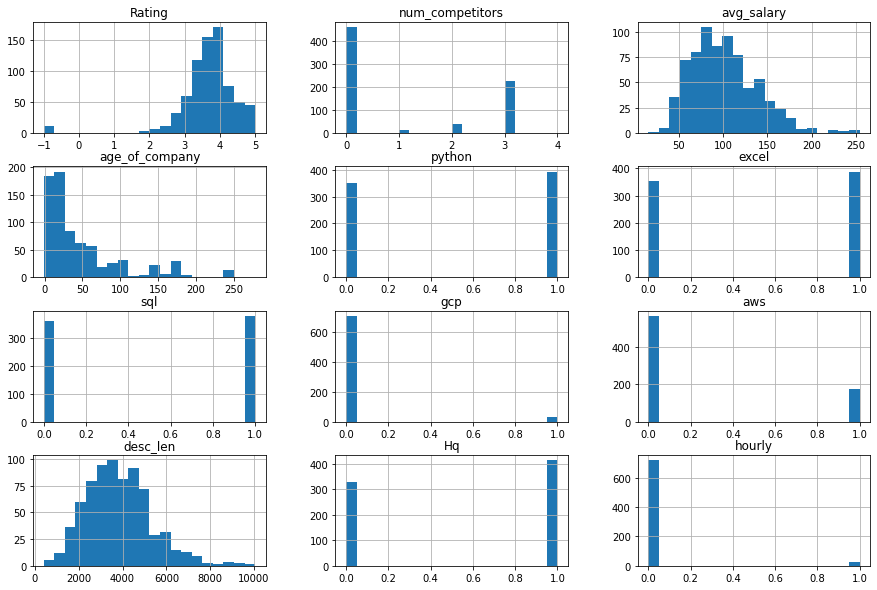

In [327]:
df.hist(bins = 20, figsize = (15,10))

                   Rating  num_competitors  avg_salary  age_of_company  \
Rating           1.000000         0.027190    0.012429        0.024665   
num_competitors  0.027190         1.000000    0.082339        0.128272   
avg_salary       0.012429         0.082339    1.000000        0.022062   
age_of_company   0.024665         0.128272    0.022062        1.000000   
python           0.144665         0.091470    0.315297       -0.098092   
excel           -0.036466        -0.031046   -0.072632        0.038659   
sql              0.134463         0.061426    0.001603       -0.117662   
gcp              0.072885        -0.065825   -0.004788       -0.072129   
aws              0.117049        -0.014860    0.172603       -0.033141   
desc_len        -0.012281         0.104620    0.069742        0.164461   
Hq               0.085033        -0.102635   -0.041313       -0.164903   
hourly          -0.019531        -0.117265   -0.241731        0.008066   

                   python     excel  

<AxesSubplot:>

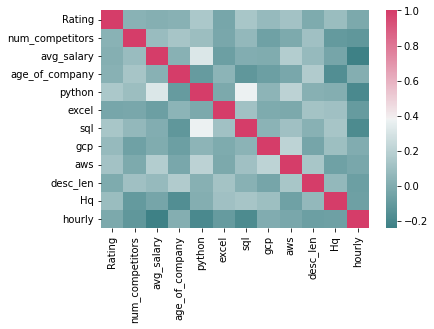

In [328]:
print(df.corr())
cmap = sns.diverging_palette(200, 0, as_cmap = True)
sns.heatmap(df.corr(), cmap = cmap)

Let's do analysis for categorical variabales

/var/folders/ph/yfqxnlss1ds28x8n8wzmqfg00000gn/T/ipykernel_2622/4116102487.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


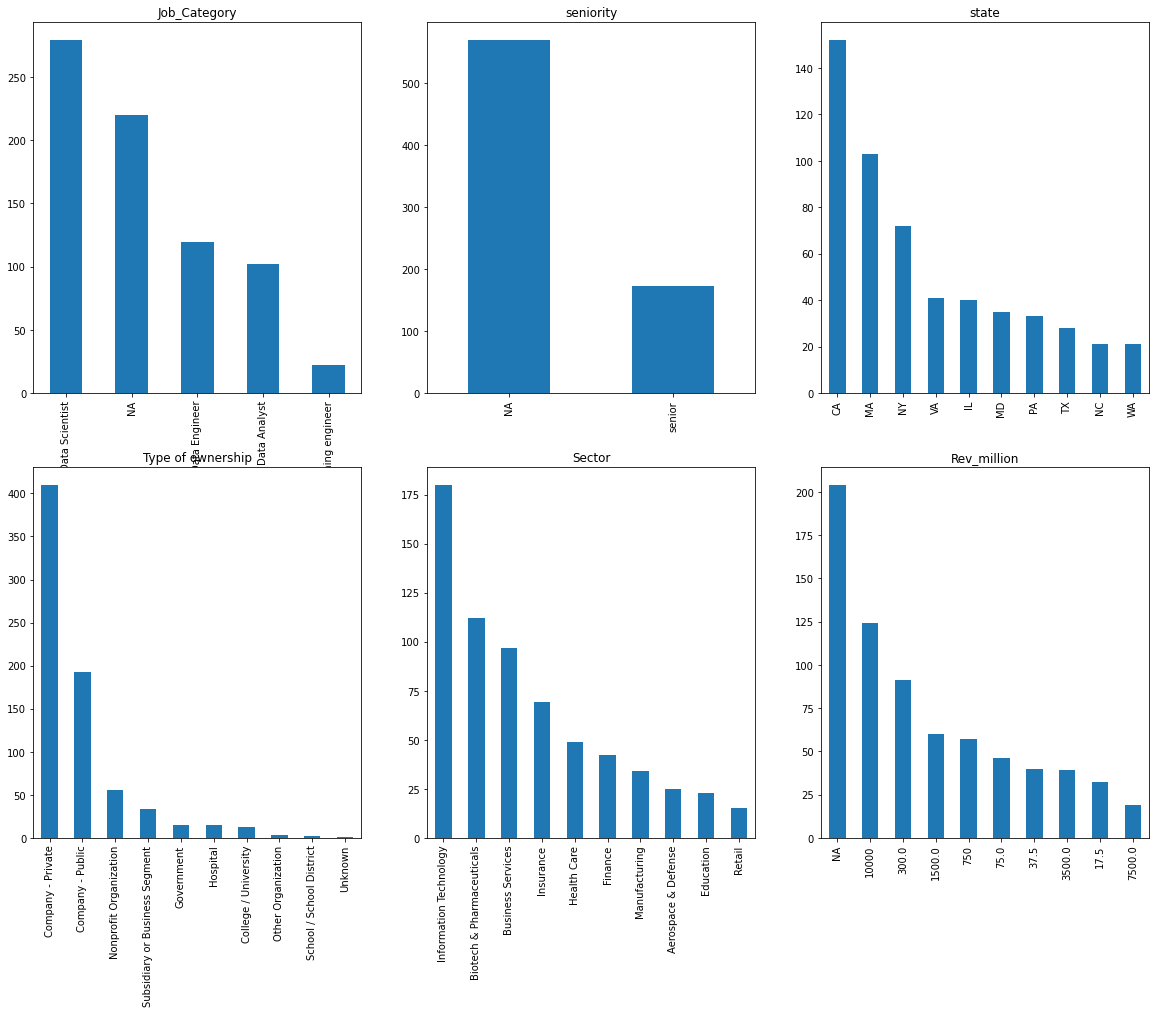

In [329]:
categorical_features = ["Job_Category", "seniority", "state", "Type of ownership","Sector", "Rev_million"]
fig, ax = plt.subplots(2, 3, figsize = (20,15))
#fig.tight_layout()
axe = ax.ravel()

for i, categorical_feature in enumerate(df[categorical_features]):
    df[categorical_feature].value_counts().head(10).plot(kind = "bar", ax=axe[i]).set_title(categorical_feature)
fig.show()

In [330]:
# Alternatively we can plot one columns after another using the below method
# for i in df[categorical_features].columns:
#     cat_num = df[categorical_features][i].value_counts()
#     chart = sns.barplot(x = cat_num.index, y = cat_num)
#     chart.set_xticklabels(chart.get_xticklabels(), rotation = 90)
#     plt.show()



Now let's see the relationships btw variables and avg_salary

## Model Building

In [331]:
import sklearn

In [332]:
# choose relevant columns
df.columns
df_models  = df[['avg_salary','Job_Category', 'seniority', 'Rating',
    'state',  'Sector', 'Type of ownership',
       'Rev_million', 'num_competitors',  'age_of_company',
       'python', 'excel', 'sql', 'gcp', 'aws','desc_len','Hq']]

df_models  = df[['avg_salary', 'Rating', 'Size', 'Type of ownership', 'Industry' , 'Sector', 
'Revenue', 'state', 'Hq','age_of_company','Job_Category', 'seniority',   'num_competitors',  
       'python', 'excel', 'sql', 'gcp', 'aws','desc_len',]]


In [333]:
# get dummy data
df_dum = pd.get_dummies(df_models)
df_dum.shape

(742, 174)

In [334]:
# train test split
from sklearn.model_selection import train_test_split
X = df_dum.drop("avg_salary", axis = 1)
y = df_dum["avg_salary"].values # make sure to return array instead of series
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)


In [335]:
# multiple linear regression
import statsmodels.api as sm 
X_sm = sm.add_constant(X)
model = sm.OLS(y,X_sm)
# model.fit().summary()


In [336]:
# LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

lm = LinearRegression()
lm.fit(X_train, y_train)


cross_val_score(lm, X_train, y_train, scoring = 'neg_mean_absolute_error', cv =3)

array([-21.9386946 , -21.53559271, -25.29855778])

In [337]:
# lasso regression
from sklearn import linear_model
lm_l = linear_model.Lasso()
np.mean(cross_val_score(lm_l,X_train,y_train, scoring = 'neg_mean_absolute_error', cv =5))


-22.49679808695675

-21.14380419823067

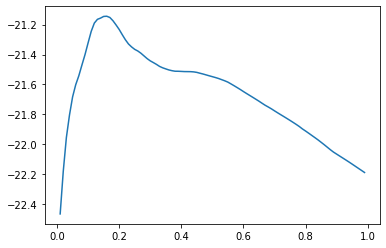

In [346]:
alpha = []
error = []
for i in range(1,100):
    lm_l = linear_model.Lasso(i/100)
    alpha.append(i/100)
    error.append(np.mean(cross_val_score(lm_l,X_train,y_train, scoring = 'neg_mean_absolute_error', cv =3)))
    
plt.plot(alpha,error)


In [349]:
optimal_alpha = alpha[error.index(max(error))]

In [350]:
# random forest (gradient boosted tree, support vector regression can be also used)
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

cross_val_score(rf,X_train,y_train,scoring = 'neg_mean_absolute_error', cv =3)

array([-16.70913333, -16.51512727, -15.6628132 ])

In [358]:
# tune model for gridsearchCV
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators':range(10,300,10),'max_features' : ('auto','sqrt','log2')}

gs = GridSearchCV(rf,parameters,scoring = 'neg_mean_absolute_error', cv = 3 )
gs.fit(X_train,y_train)
# GridSearchCV(estimator=SVC(),
#              param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf')})

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'max_features': ('auto', 'sqrt', 'log2'),
                         'n_estimators': range(10, 300, 10)},
             scoring='neg_mean_absolute_error')

In [360]:
# test emsambles
gs.best_score_
gs.best_estimator_

RandomForestRegressor(n_estimators=50)

In [372]:
# test ensembles
lm = LinearRegression()
lm.fit(X_train,y_train)
tpred_lm = lm.predict(X_test)
lm_l = linear_model.Lasso(alpha = 0.16)
lm_l.fit(X_train,y_train)
tpred_lm_l = lm_l.predict(X_test)
tpred_rf = gs.best_estimator_.predict(X_test)


In [376]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_test,tpred_lm))
print(mean_absolute_error(y_test,tpred_lm_l))
print(mean_absolute_error(y_test,tpred_rf))

22.117904333516258
22.962056917727487
12.505758389261743
22.166233728517586
